***
# Name: Pratik Sayanekar | Student ID: 20200161
## COMP47650 Deep Learning Project
## Dataset -  B1: Twitter Sentiment Classification
***

In [1]:
! pip install -q scikit-plot
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

# **Import**

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import string
import numpy as np

In [3]:
import sys
filePath = '/Users/pratiksayanekar/Documents/DL_20200161'
#filePath = '/content/drive/My Drive/DeepLearning'
sys.path.append(filePath)

In [4]:
from utils.basic_utilities import Utils
from models.LSTM_1 import LSTM_Model
from models.CNN_1 import CNN_Model
from models.Word2Vec_1 import Word2VecModel
from models.BiLSTM import BiLSTM_Model

/Users/pratiksayanekar/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [5]:
from sklearn.metrics import classification_report

# **Reading Preprocessed Data**

In [6]:
#df = pd.read_csv('/content/drive/MyDrive/DeepLearning/Data/preprocessed_data.csv')
df = pd.read_csv('{}/Data/preprocessed_data.csv'.format(filePath))
df.head()

,emotion,text
0,disappointed,rt oh fuck wrote fil grinning_face_with_sweatnsorry spot isappointed_face
1,disappointed,feel shamed
2,disappointed,feeling little bit defeated steps faith need try resolve problem
3,happy,imagine reaction guy called jj kfc saw man ve started crying lmao
4,disappointed,wouldnt feel burdened live life testament sacrifice love pure innocent great mighty


In [7]:
df.text = df.text.astype(str)

# **Splitting dataset into train(80%) and test(20%)**

In [8]:
util = Utils()
X_train, X_test, y_train, y_test = util.split_data(df)
print("The shape of train data: ",X_train.shape)
print("The shape of train target: ",y_train.shape)
print("The shape of test data: ",X_test.shape)
print("The shape of test target: ",y_test.shape)

Initialization of Utilities...
The shape of train data:  (733260,)
The shape of train target:  (733260,)
The shape of test data:  (183315,)
The shape of test target:  (183315,)


In [9]:
y_test.value_counts()

disappointed    62743
happy           60374
angry           60198
Name: emotion, dtype: int64

In [10]:
target_converted_train, target_converted_test = util.one_hot_target_variable(y_train, y_test)
print("After one hot encoding of target variable...")
print("The shape of train target: ", target_converted_train.shape)
print("The shape of test target: ", target_converted_test.shape)

After one hot encoding of target variable...
The shape of train target:  (733260, 3)
The shape of test target:  (183315, 3)


# **Tokenization and Padding of each tweet**

In [11]:
# max_len = util.max_len(df)
max_len = 100
print("Maximum length of tweet:", max_len)

Maximum length of tweet: 100


In [12]:
train_converted, test_converted, tokenizer = util.tokenization_padding_oov_token(X_train, X_test, max_len)
print("After Tokenization and Padding...")
print("The shape of train data: ", train_converted.shape)
print("The shape of test data: ", test_converted.shape)

After Tokenization and Padding...
The shape of train data:  (733260, 100)
The shape of test data:  (183315, 100)


In [13]:
vocab_length = len(tokenizer.word_index) + 1

# Glove : Pretrained word embedding

In [14]:
path_to_glove_file = '{}/Data/glove.6B.100d.txt'.format(filePath)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((vocab_length, 100))
for word, token in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[token] = embedding_vector
        hits += 1
    else:
        misses += 1
        
print("Embedding Matrix Shape:", embedding_matrix.shape)

Found 400000 word vectors.
Embedding Matrix Shape: (159425, 100)


# **Deep Learning Models**

In [15]:
EPOCH = 10
BATCH_SIZE = 2048 # 1024

# **CNN Model**

In [16]:
# Below method is commented as now for embedding layer some weight matrix is also provided as input.

# cnn = CNN_Model()
# model = cnn.create_model(embed_dim = 100, num_filters = 128, 
#                           input_len = train_converted.shape[1], feature = 200000, 
#                           drop_out = 0.5, num_words=4)
# model.summary()

In [17]:
cnn = CNN_Model()
model = cnn.create_model(embed_dim = max_len, num_filters = 128, 
                          input_len = train_converted.shape[1], feature = vocab_length, 
                          drop_out = 0.3, num_words=4, embedding_matrix = embedding_matrix)
model.summary()

CNN Model Initialization...
Model Created Successfully...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          15942500  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 97, 128)           51328     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 15,994,215
Trainable params: 15,994,215
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(train_converted, target_converted_train, epochs = EPOCH, 
                    batch_size=BATCH_SIZE, validation_split=0.2,
                    callbacks=cnn.callbacks)

Epoch 1/10
287/287 [==============================] - 136s 471ms/step - loss: 0.8157 - acc: 0.6168 - val_loss: 0.2725 - val_acc: 0.8817

Epoch 00001: val_loss improved from inf to 0.27246, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN/assets
Epoch 2/10
287/287 [==============================] - 129s 449ms/step - loss: 0.2830 - acc: 0.8793 - val_loss: 0.2487 - val_acc: 0.8917

Epoch 00002: val_loss improved from 0.27246 to 0.24869, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN/assets
Epoch 3/10
287/287 [==============================] - 129s 450ms/step - loss: 0.2486 - acc: 0.8941 - val_loss: 0.2410 - val_acc: 0.8948

Epoch 00003: val_loss improved from 0.24869 to 0.24102, saving model to /Users/pratiksayanekar/Documents/DL_20200161/ch

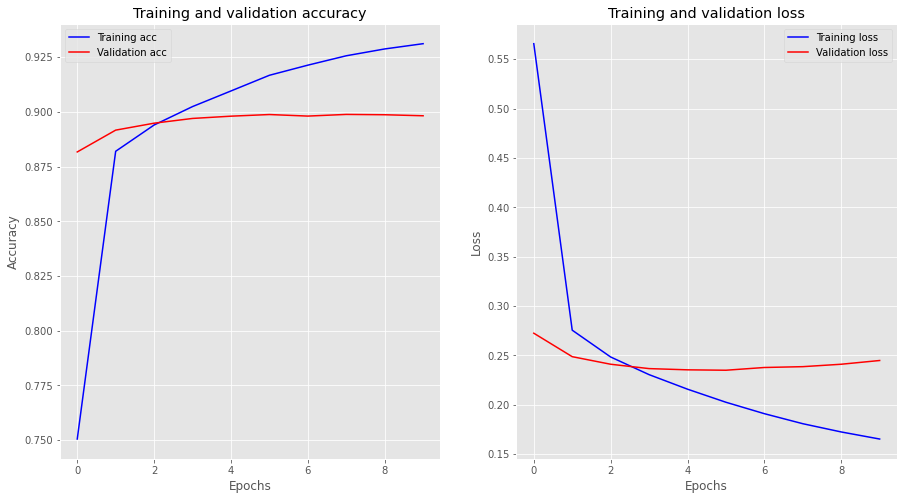

In [19]:
util.plot_accuracy_loss(history, 'CNN')

# **Evaluation**

In [20]:
model = cnn.load_saved_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          15942500  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 97, 128)           51328     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 15,994,215
Trainable params: 15,994,215
Non-trainable params: 0
_________________________________________________________________


In [21]:
score, acc = model.evaluate(test_converted, target_converted_test, verbose = 2, batch_size = BATCH_SIZE)
print("The loss of this model: %.2f" % (score))
print("The accuracy of this model: %.2f" % (acc))

90/90 - 8s - loss: 0.2354 - acc: 0.8987
The loss of this model: 0.24
The accuracy of this model: 0.90


In [22]:
y_pred = model.predict(test_converted)

Confusion Matrix: 
 [[53748  7472  2314]
 [ 5835 54514  1573]
 [  615   757 56487]]


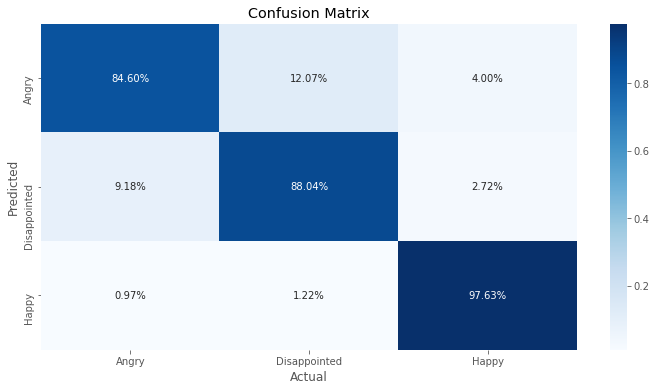

In [23]:
test,pred = util.plot_confusion_matrix(y_pred, target_converted_test, 'CNN')

In [24]:
print("Classification Report: ", classification_report(test, pred))

Classification Report:                precision    recall  f1-score   support

           0       0.89      0.85      0.87     63534
           1       0.87      0.88      0.87     61922
           2       0.94      0.98      0.96     57859

    accuracy                           0.90    183315
   macro avg       0.90      0.90      0.90    183315
weighted avg       0.90      0.90      0.90    183315



# **CNN_v2**

In [25]:
# Below method is commented as now for embedding layer some weight matrix is also provided as input.

# cnn = CNN_Model()
# model = cnn.create_model_v2(embed_dim = 100, num_filters = 128, 
#                           input_len = train_converted.shape[1], feature = 200000, 
#                           drop_out = 0.8, num_words=4)
# model.summary()

In [26]:
cnn = CNN_Model()
model = cnn.create_model_v2(embed_dim = max_len, num_filters = 128, 
                          input_len = train_converted.shape[1], feature = vocab_length, 
                          drop_out = 0.3, num_words=4, embedding_matrix = embedding_matrix )
model.summary()

CNN Model Initialization...
Model Created Successfully...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          15942500  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 128)          51328     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 128)          65664     
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 128)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
______________________________________________________________

In [27]:
history = model.fit(train_converted, target_converted_train, epochs = EPOCH, 
                    batch_size=BATCH_SIZE, validation_split=0.2,
                    callbacks=cnn.callbacks_v2)

Epoch 1/10
287/287 [==============================] - 260s 904ms/step - loss: 0.7478 - acc: 0.6363 - val_loss: 0.2578 - val_acc: 0.8865

Epoch 00001: val_loss improved from inf to 0.25780, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN_v2/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN_v2/assets
Epoch 2/10
287/287 [==============================] - 256s 892ms/step - loss: 0.2731 - acc: 0.8827 - val_loss: 0.2389 - val_acc: 0.8948

Epoch 00002: val_loss improved from 0.25780 to 0.23894, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN_v2/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN_v2/assets
Epoch 3/10
287/287 [==============================] - 252s 878ms/step - loss: 0.2388 - acc: 0.8976 - val_loss: 0.2316 - val_acc: 0.8973

Epoch 00003: val_loss improved from 0.23894 to 0.23157, saving model to /Users/pratiksayanekar/Documents/DL

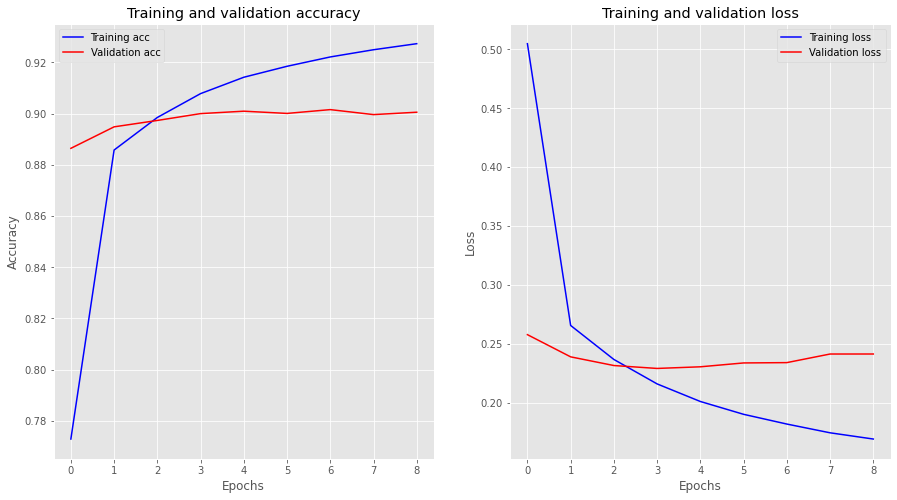

In [28]:
util.plot_accuracy_loss(history, 'CNN_v2')

# **Evaluation**

In [29]:
model = cnn.load_saved_model_v2()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          15942500  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 128)          51328     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 128)          65664     
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 128)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

In [30]:
score, acc = model.evaluate(test_converted, target_converted_test, verbose = 2, batch_size = BATCH_SIZE)
print("The loss of this model: %.2f" % (score))
print("The accuracy of this model: %.2f" % (acc))

90/90 - 19s - loss: 0.2317 - acc: 0.8995
The loss of this model: 0.23
The accuracy of this model: 0.90


In [31]:
y_pred = model.predict(test_converted)

Confusion Matrix: 
 [[54018  7683  2460]
 [ 5767 54497  1544]
 [  413   563 56370]]


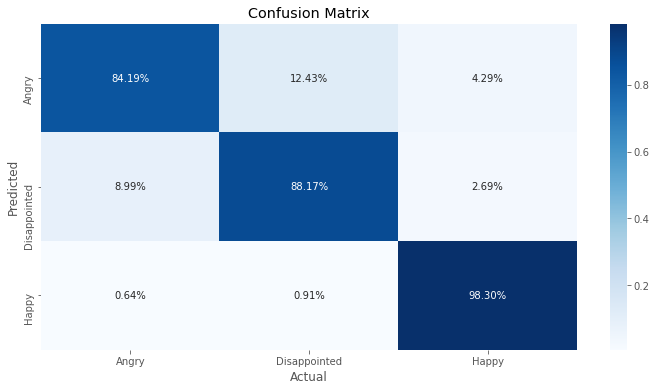

In [32]:
test,pred = util.plot_confusion_matrix(y_pred, target_converted_test, 'CNN_v2')

In [33]:
print("Classification Report: ", classification_report(test, pred))

Classification Report:                precision    recall  f1-score   support

           0       0.90      0.84      0.87     64161
           1       0.87      0.88      0.88     61808
           2       0.93      0.98      0.96     57346

    accuracy                           0.90    183315
   macro avg       0.90      0.90      0.90    183315
weighted avg       0.90      0.90      0.90    183315



# **LSTM Model**

In [34]:
# Below method is commented as now for embedding layer some weight matrix is also provided as input.

# lstm = LSTM_Model()
# model = lstm.create_model(embed_dim = 100, lstm_out = 64, 
#                           input_len = train_converted.shape[1], feature = 200000, 
#                           drop_out = 0.8)
# model.summary()

In [35]:
lstm = LSTM_Model()
model = lstm.create_model(embed_dim = max_len, lstm_out = 64, 
                          input_len = train_converted.shape[1], feature = vocab_length, 
                          drop_out = 0.3, embedding_matrix = embedding_matrix)
model.summary()

LSTM Model Initialization...
Model Created Successfully...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          15942500  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 15,984,935
Trainable params: 15,984,935
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit(train_converted, target_converted_train, epochs = EPOCH, 
                    batch_size= BATCH_SIZE, validation_split=0.2,
                    callbacks=lstm.callbacks)

Epoch 1/10
287/287 [==============================] - 404s 1s/step - loss: 0.8185 - acc: 0.6076 - val_loss: 0.2796 - val_acc: 0.8824

Epoch 00001: val_loss improved from inf to 0.27959, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM/assets
Epoch 2/10
287/287 [==============================] - 397s 1s/step - loss: 0.2992 - acc: 0.8732 - val_loss: 0.2427 - val_acc: 0.8938

Epoch 00002: val_loss improved from 0.27959 to 0.24273, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM/assets
Epoch 3/10
287/287 [==============================] - 398s 1s/step - loss: 0.2525 - acc: 0.8923 - val_loss: 0.2320 - val_acc: 0.8980

Epoch 00003: val_loss improved from 0.24273 to 0.23203, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpo

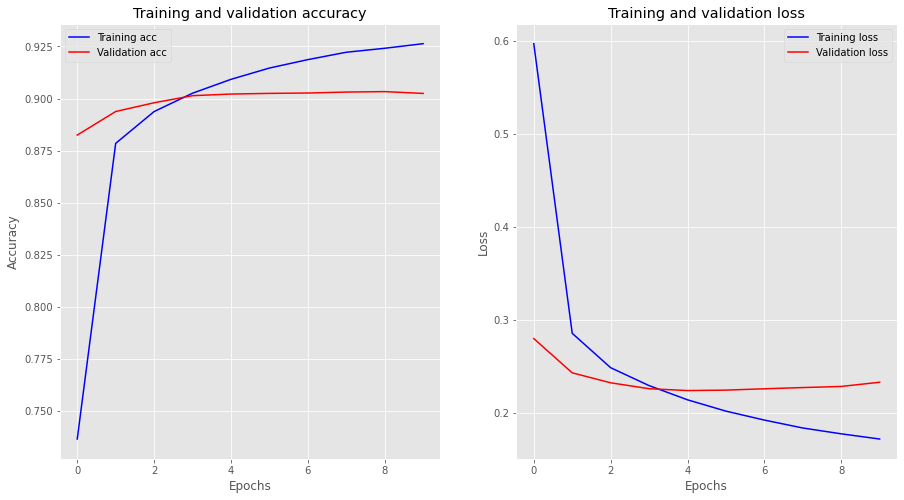

In [37]:
util.plot_accuracy_loss(history, 'LSTM')

# **Evaluation**

In [38]:
model = lstm.load_saved_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          15942500  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 15,984,935
Trainable params: 15,984,935
Non-trainable params: 0
_________________________________________________________________


In [39]:
score, acc = model.evaluate(test_converted, target_converted_test, verbose = 2, batch_size = BATCH_SIZE)
print("The loss of this model: %.2f" % (score))
print("The accuracy of this model: %.2f" % (acc))

90/90 - 23s - loss: 0.2261 - acc: 0.9019
The loss of this model: 0.23
The accuracy of this model: 0.90


In [40]:
y_pred = model.predict(test_converted)

Confusion Matrix: 
 [[53980  7314  2345]
 [ 5838 54891  1571]
 [  380   538 56458]]


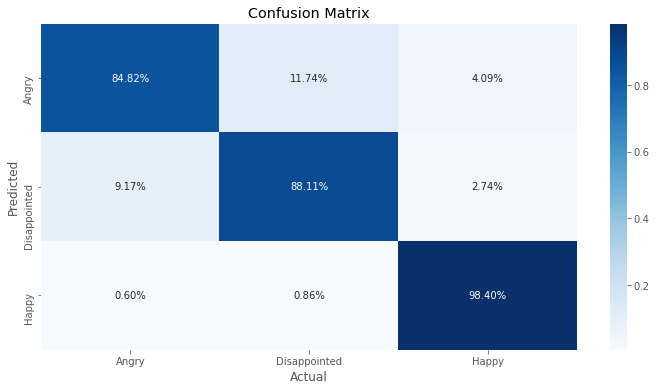

In [41]:
test, pred = util.plot_confusion_matrix(y_pred, target_converted_test, 'LSTM')

In [42]:
print("Classification Report: ", classification_report(test, pred))

Classification Report:                precision    recall  f1-score   support

           0       0.90      0.85      0.87     63639
           1       0.87      0.88      0.88     62300
           2       0.94      0.98      0.96     57376

    accuracy                           0.90    183315
   macro avg       0.90      0.90      0.90    183315
weighted avg       0.90      0.90      0.90    183315



# **LSTM_v2**

In [43]:
# Below method is commented as now for embedding layer some weight matrix is also provided as input.

# lstm = LSTM_Model()
# model = lstm.create_model_v2(embed_dim = 100, lstm_out = 64, 
#                           input_len = train_converted.shape[1], feature = 200000, 
#                           drop_out = 0.8)
# model.summary()

In [44]:
lstm = LSTM_Model()
model = lstm.create_model_v2(embed_dim = max_len, lstm_out = 64, 
                          input_len = train_converted.shape[1], feature = vocab_length, 
                          drop_out = 0.3, embedding_matrix = embedding_matrix )
model.summary()

LSTM Model Initialization...
Model Created Successfully...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          15942500  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 64)           42240     
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 100, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 64)           33024     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_____________________________________________________________

In [45]:
history = model.fit(train_converted, target_converted_train, epochs = EPOCH, 
                    batch_size= BATCH_SIZE, validation_split=0.2,
                    callbacks=lstm.callbacks_v2)

Epoch 1/10
287/287 [==============================] - 1029s 4s/step - loss: 0.8381 - acc: 0.5809 - val_loss: 0.2674 - val_acc: 0.8818

Epoch 00001: val_loss improved from inf to 0.26741, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM_v2/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM_v2/assets
Epoch 2/10
287/287 [==============================] - 994s 3s/step - loss: 0.2932 - acc: 0.8725 - val_loss: 0.2405 - val_acc: 0.8938

Epoch 00002: val_loss improved from 0.26741 to 0.24051, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM_v2/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM_v2/assets
Epoch 3/10
287/287 [==============================] - 776s 3s/step - loss: 0.2565 - acc: 0.8883 - val_loss: 0.2313 - val_acc: 0.8982

Epoch 00003: val_loss improved from 0.24051 to 0.23126, saving model to /Users/pratiksayanekar/Documents/DL_202

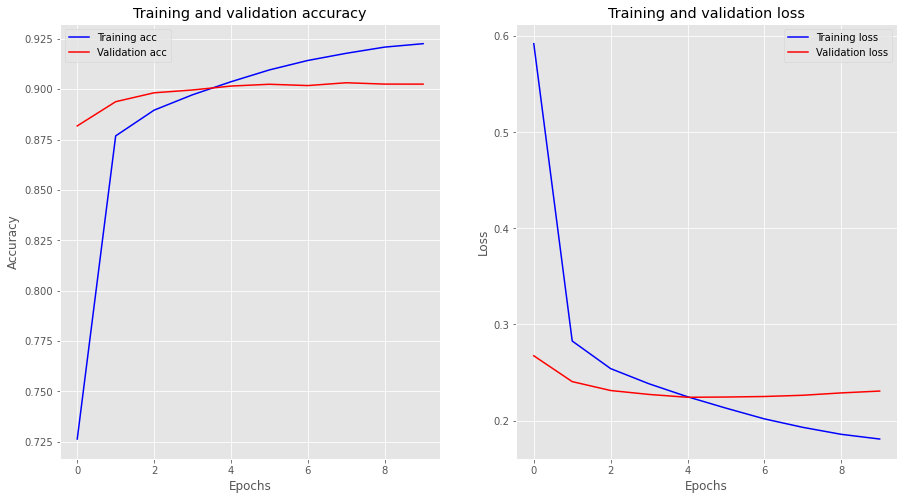

In [46]:
util.plot_accuracy_loss(history, 'LSTM_v2')

# **Evaluation**

In [47]:
model = lstm.load_saved_model_v2()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          15942500  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 64)           42240     
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 100, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 64)           33024     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [48]:
score, acc = model.evaluate(test_converted, target_converted_test, verbose = 2, batch_size = BATCH_SIZE)
print("The loss of this model: %.2f" % (score))
print("The accuracy of this model: %.2f" % (acc))

90/90 - 46s - loss: 0.2271 - acc: 0.9011
The loss of this model: 0.23
The accuracy of this model: 0.90


In [49]:
y_pred = model.predict(test_converted)

Confusion Matrix: 
 [[54272  7710  2450]
 [ 5550 54556  1570]
 [  376   477 56354]]


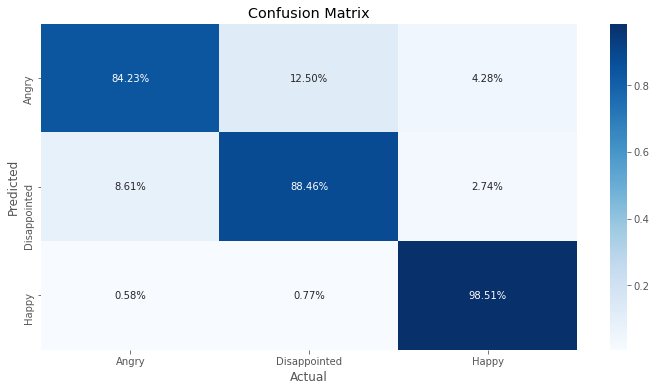

In [50]:
test, pred = util.plot_confusion_matrix(y_pred, target_converted_test, 'LSTM_v2')

In [51]:
print("Classification Report: ", classification_report(test, pred))

Classification Report:                precision    recall  f1-score   support

           0       0.90      0.84      0.87     64432
           1       0.87      0.88      0.88     61676
           2       0.93      0.99      0.96     57207

    accuracy                           0.90    183315
   macro avg       0.90      0.90      0.90    183315
weighted avg       0.90      0.90      0.90    183315



# **BiLSTM**

In [16]:
bi_lstm = BiLSTM_Model()
model = bi_lstm.create_model(embed_dim = max_len, lstm_out = 100, input_len = train_converted.shape[1], 
                             feature = vocab_length, drop_out = 0.3, embedding_matrix = embedding_matrix)
model.summary()

BiLSTM Model Initialization...
Model Created Successfully...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          15942500  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 200)          160800    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 200)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 200)          240800    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 100)           100100    
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_____________________________________________________________

In [17]:
history = model.fit(train_converted, target_converted_train, batch_size=BATCH_SIZE, epochs=EPOCH,
                    validation_split=0.2, callbacks=bi_lstm.callbacks,  verbose=1)

Epoch 1/10
287/287 [==============================] - 2493s 9s/step - loss: 0.7211 - acc: 0.6615 - val_loss: 0.2597 - val_acc: 0.8873


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


Epoch 2/10
287/287 [==============================] - 3104s 11s/step - loss: 0.2584 - acc: 0.8888 - val_loss: 0.2331 - val_acc: 0.8979


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


Epoch 3/10
287/287 [==============================] - 3012s 10s/step - loss: 0.2210 - acc: 0.9058 - val_loss: 0.2261 - val_acc: 0.9019


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


Epoch 4/10
287/287 [==============================] - 2603s 9s/step - loss: 0.2011 - acc: 0.9146 - val_loss: 0.2261 - val_acc: 0.9020
Epoch 5/10
287/287 [==============================] - 2275s 8s/step - loss: 0.1837 - acc: 0.9218 - val_loss: 0.2317 - val_acc: 0.9017
Epoch 6/10
287/287 [==============================] - 2583s 9s/step - loss: 0.1707 - acc: 0.9268 - val_loss: 0.2337 - val_acc: 0.9020
Epoch 7/10
287/287 [==============================] - 2917s 10s/step - loss: 0.1635 - acc: 0.9295 - val_loss: 0.2339 - val_acc: 0.9025
Epoch 8/10
287/287 [==============================] - 2882s 10s/step - loss: 0.1570 - acc: 0.9317 - val_loss: 0.2444 - val_acc: 0.9014


# **Evaluation**

In [19]:
model = bi_lstm.load_saved_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          15942500  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 200)          160800    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 200)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 200)          240800    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 100)           100100    
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1

In [20]:
score, acc = model.evaluate(test_converted, target_converted_test, verbose = 2, batch_size = BATCH_SIZE)
print("The loss of this model: %.2f" % (score))
print("The accuracy of this model: %.2f" % (acc))

90/90 - 196s - loss: 0.2275 - acc: 0.9009
The loss of this model: 0.23
The accuracy of this model: 0.90


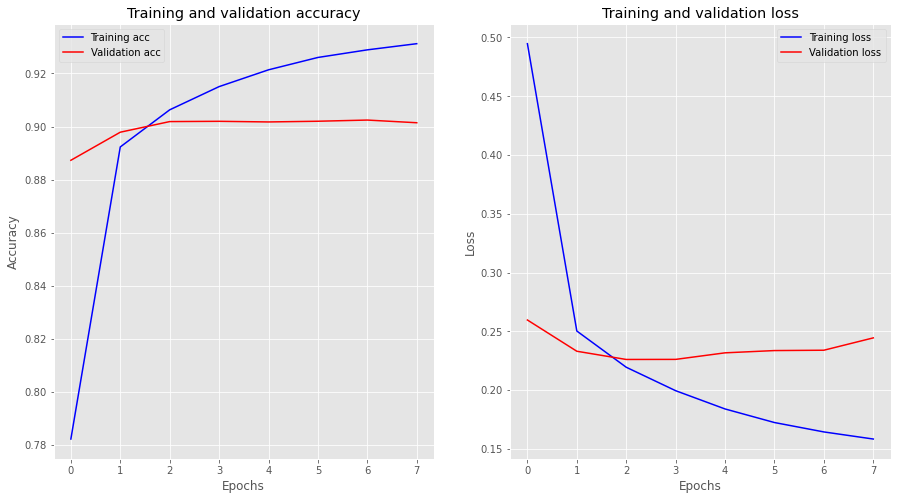

In [21]:
util.plot_accuracy_loss(history, 'BiLSTM')

# **Prediction** 

In [22]:
y_pred = model.predict(test_converted)

Confusion Matrix: 
 [[54031  7534  2338]
 [ 5734 54671  1586]
 [  433   538 56450]]


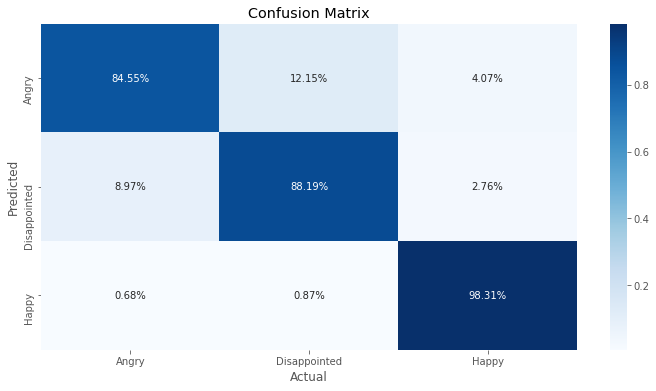

In [23]:
test, pred = util.plot_confusion_matrix(y_pred, target_converted_test, 'BiLSTM')

In [24]:
print("Classification Report: ", classification_report(test, pred))

Classification Report:                precision    recall  f1-score   support

           0       0.90      0.85      0.87     63903
           1       0.87      0.88      0.88     61991
           2       0.94      0.98      0.96     57421

    accuracy                           0.90    183315
   macro avg       0.90      0.90      0.90    183315
weighted avg       0.90      0.90      0.90    183315

